In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns_c = sns.color_palette(palette='deep')


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel, DotProduct
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


# Trabalhando em problemas simples

Nesse notebook, iremos analisar o funcionamento do Processo de Regressão Gaussiana em alguns problemas simples:
*   Análise de série temporal simples com tendência (regressão linear)
*   Análise de série temporal com tendência e sazonalidade
*   Análise de série temporal com sazonalidade e não linearidade

O objetivo aqui é visualizar o funcionamento do GPR, observando as funções amostras a priori e a posteriori. Iremos discutir o impacto de diferentes funções kernel e verificar algumas propriedades fundamentais de cada uma delas.

Em seguida, iremos desenvolver funções para aplicar métricas de avaliações aos modelos treinados. Devemos ser capazes (referência do livro) de quantificar o r², o mse, e o mape. Devemos ser capazes de observar, também, os resíduos do modelo ao longo do tempo.

Por fim, tais métricas devem ser aplicadas para analisar o efeito do tamanho do dataset no processo de treinamento. Utilize o TimeSeriesSplit. Gere gráficos de pontos da evolução das métricas ao longo dos splits. Quão pequeno o conjunto de treino pode ser para que possa-se ainda realizar o treinamento?


# Plotando funções amostras

Aqui definimos uma função (https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html) para plotar amostras de gaussianas tanto a priori quanto a posteriori. Essa é uma função auxiliar para o restante do notebook


In [2]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 100, 200)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)


    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([-5, 5])
    ax.grid()

# Problema #1 - Sazonalidade

In [3]:
# Number of samples. 
n = 100
# Generate "time" variable. 
t = np.arange(n)

# O tempo t representa a variável x
data_df = pd.DataFrame({'t' : t})


In [4]:
# Definindo algumas funções a partir desse t

def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    return y1

def linear_trend(t, alfa):
    """Scale vector by a scalar"""
    y2 = alfa * t**1.5
    return y2

# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)

# Create linear trend

data_df['linear'] = data_df['t'].apply(lambda x: linear_trend(x, alfa = 0.1))
data_df['seasonal'] = data_df['t'].apply(lambda x: seasonal(x, amplitude=2, period=40))

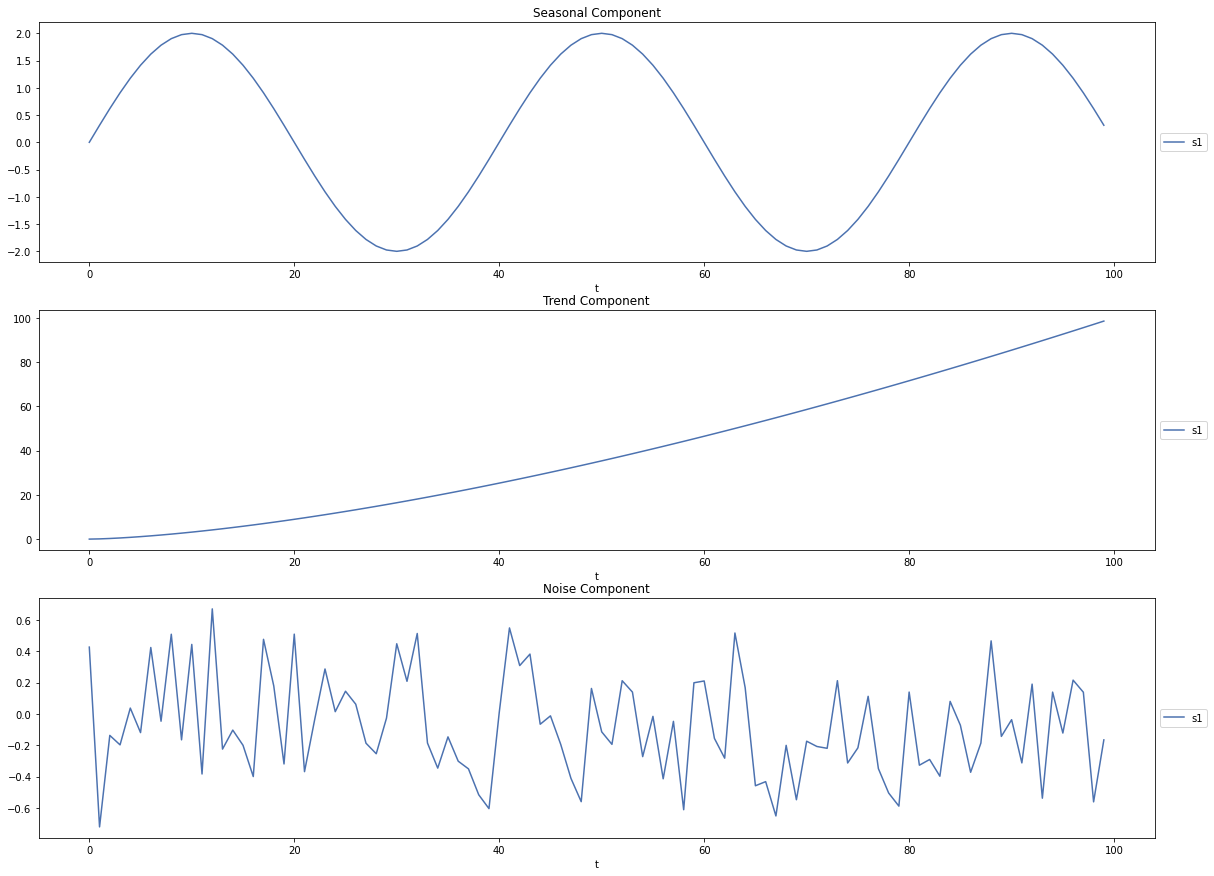

In [5]:
# Plotando os resultados obtidos

fig, ax = plt.subplots(figsize = (20,15), nrows=3, ncols = 1)
sns.lineplot(x='t', y='seasonal', data=data_df, color=sns_c[0], label='s1', ax=ax[0]) 
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set(title='Seasonal Component', xlabel='t', ylabel='');

sns.lineplot(x='t', y='linear', data=data_df, color=sns_c[0], label='s1', ax=ax[1]) 
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set(title='Trend Component', xlabel='t', ylabel='');

sns.lineplot(x='t', y='epsilon', data=data_df, color=sns_c[0], label='s1', ax=ax[2]) 
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].set(title='Noise Component', xlabel='t', ylabel='');

Agora que temos um conjunto de dados obtidos, vamos analizar uma primeira série temporal: apenas com tendência e ruído aleatório. Iremos visualizar as funções priori e posteriori utilizando um kernel apenas RBF e um kernel ExpSineSquared + WhiteKernel. Em seguida, vamos definir uma função de avaliação com as métricas pré-definidas.

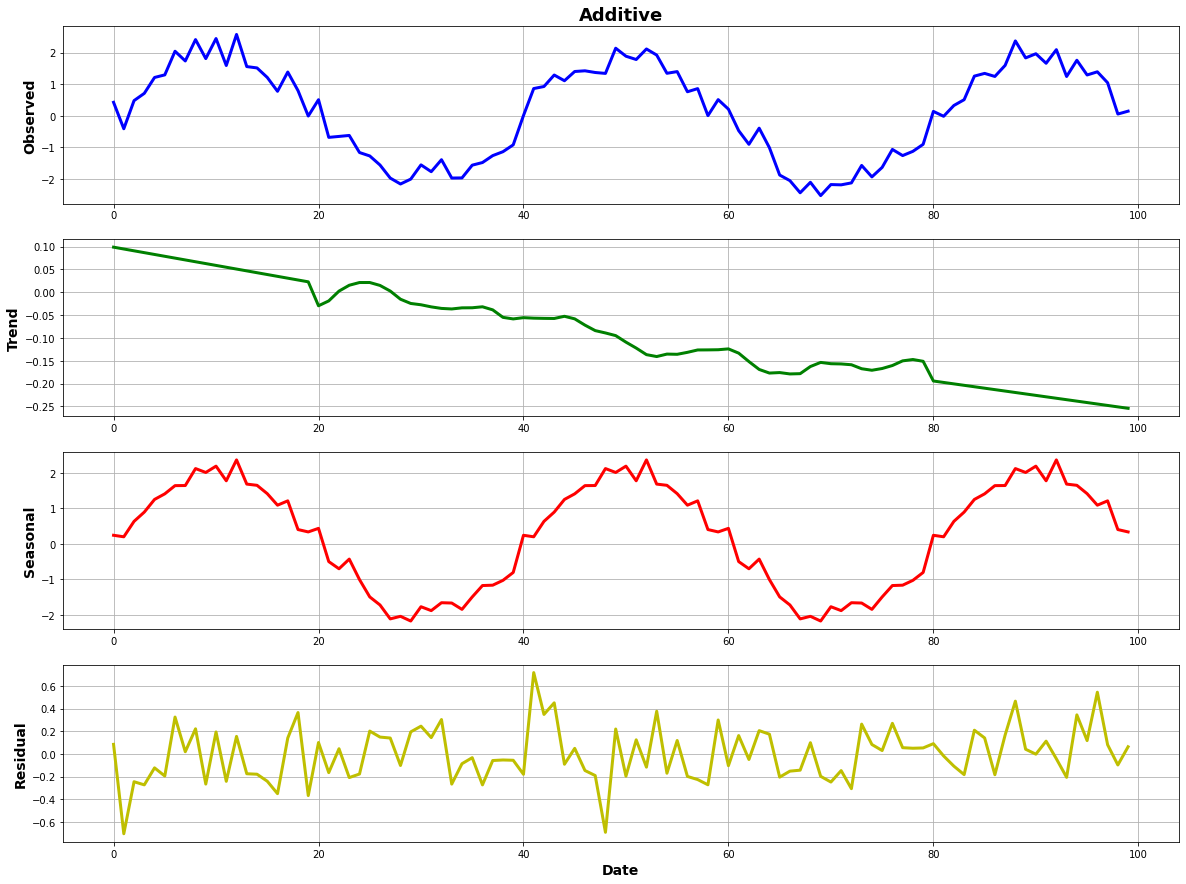

In [6]:
data_df['y1'] = data_df['seasonal'] + data_df['epsilon']


# Agregating in months

ts = data_df['y1']

# Decomposing using seasonal_decompose

result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq', period = 40)
#result_mult = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq', period = 1)

# Plot
fig, axs = plt.subplots(figsize = (20,15), nrows = 4, ncols = 1)


axs[0].plot(result_add.observed, linewidth = 3, color = 'b')
axs[0].set_ylabel('Observed', fontsize = 14, fontweight = 'bold')
axs[0].set_title('Additive', fontsize = 18, fontweight = 'bold')
axs[0].grid(True)


axs[1].plot(result_add.trend,linewidth = 3, color = 'g')
axs[1].set_ylabel('Trend', fontsize = 14, fontweight = 'bold')
axs[1].grid(True)

axs[2].plot(result_add.seasonal,linewidth = 3, color = 'r')
axs[2].set_ylabel('Seasonal', fontsize = 14, fontweight = 'bold')
axs[2].grid(True)

axs[3].plot(result_add.resid,linewidth = 3, color = 'y')
axs[3].set_ylabel('Residual', fontsize = 14, fontweight = 'bold')
axs[3].set_xlabel('Date', fontsize = 14, fontweight = 'bold')
axs[3].grid(True)


plt.show()


Como podemos observar pela decomposição, claramente temos uma série temporal apenas com componente sazonal. Kernels como o ExpSineSquared são altamente recomendados. Vamos analizar rapidamente o que acontece com as funções priori e posteriori com alguns kernels

## Kernel 1: ExpSineSquared

In [7]:
# Preparando os dados

X = np.array(data_df['t']).reshape(-1,1)
y = np.array(data_df['y1'])

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [8]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 

# Criando o modelo gaussiano

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp1_fitted = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)
gp1_fitted.fit(X_train,y_train)


GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True)

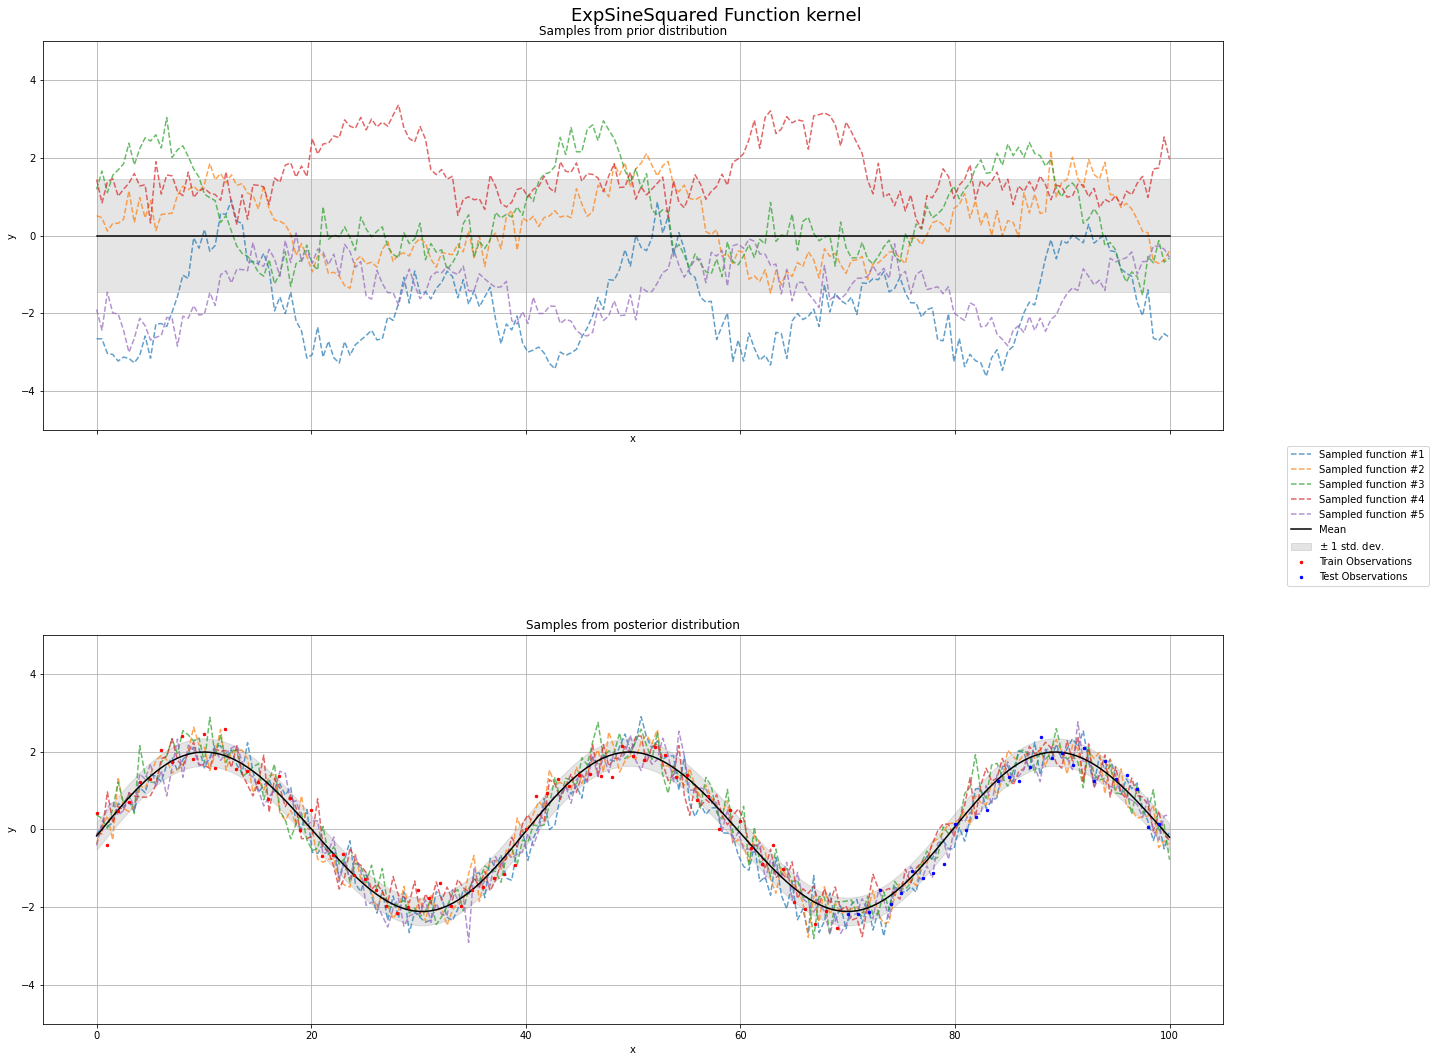

In [9]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp1, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp1_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("ExpSineSquared Function kernel", fontsize=18)
plt.tight_layout()

In [10]:
print(f'R2 Score Train = {gp1_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp1_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp1_fitted.predict(X_test)): 0.3f}')

R2 Score Train =  0.948
R2 Score Test =  0.954
MAE Train =  0.275
MAE Test =  0.265
MAPE Train =  2.278
MAPE Test =  1.428


## Kernel 2: RBF

In [11]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  RBF()

kernel_2  = k0 + k1 

# Criando o modelo gaussiano

gp2 = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp2_fitted = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)
gp2_fitted.fit(X_train,y_train)


GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)

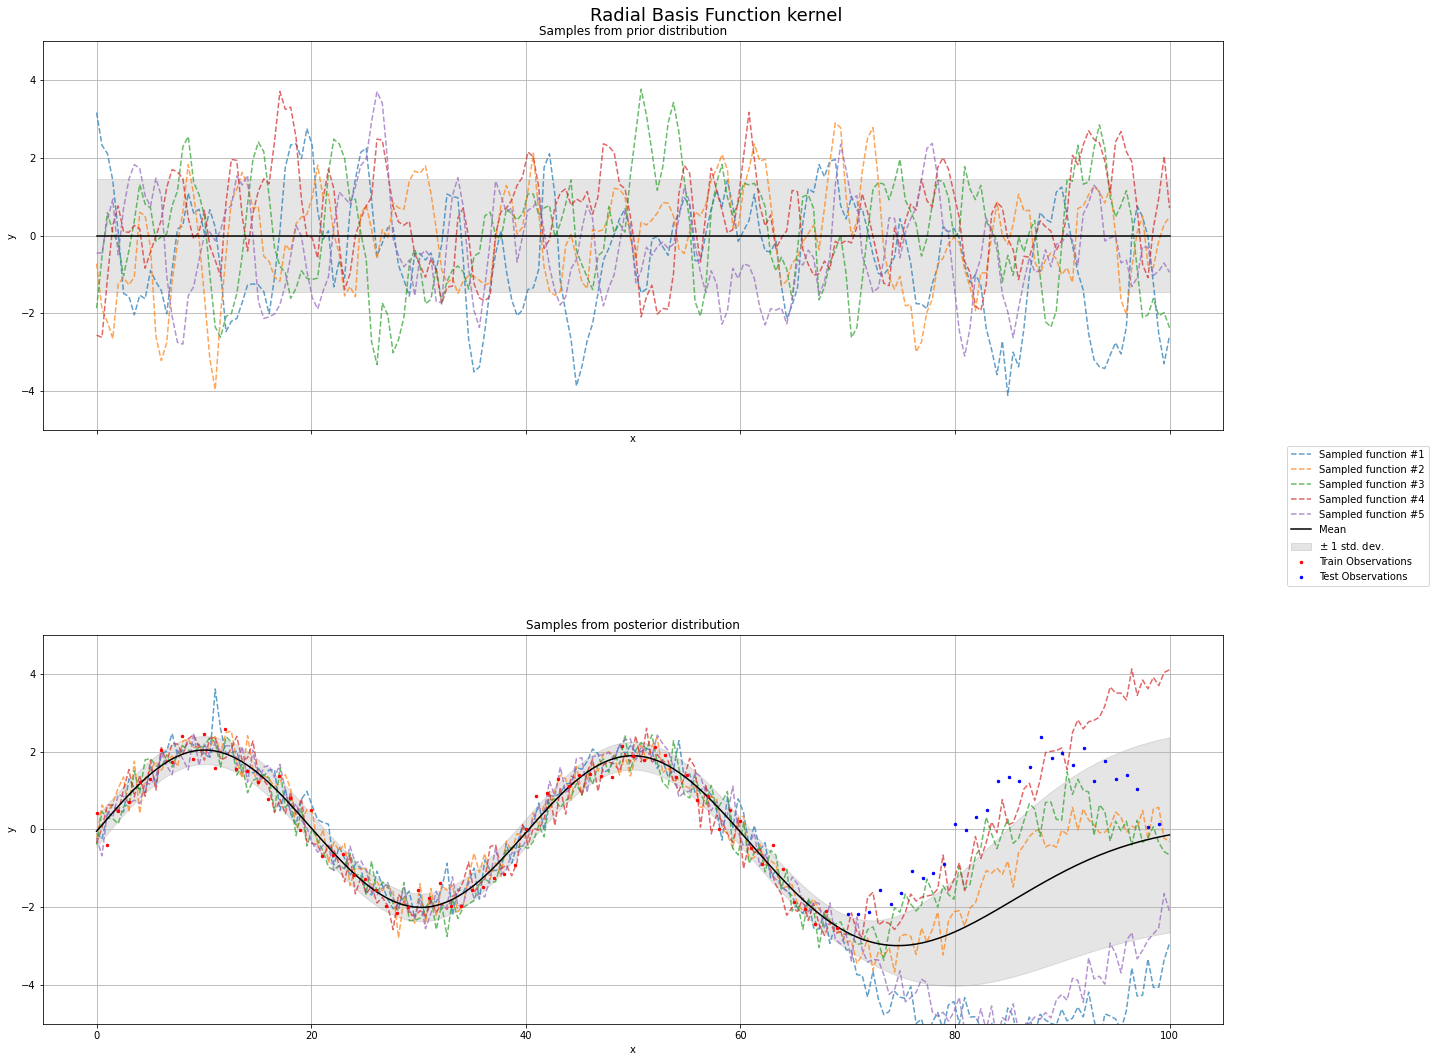

In [12]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp2, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp2_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Radial Basis Function kernel", fontsize=18)
plt.tight_layout()

In [13]:
print(f'R2 Score Train = {gp2_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp2_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp2_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp2_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp2_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp2_fitted.predict(X_test)): 0.3f}')

R2 Score Train =  0.952
R2 Score Test = -1.446
MAE Train =  0.269
MAE Test =  2.052
MAPE Train =  2.449
MAPE Test =  8.315


## Kernel 3: Linear Kernel

In [14]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=1e-4) * \
  DotProduct(sigma_0=1)

kernel_3  = k0 + k1 

# Criando o modelo gaussiano

gp3 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp3_fitted = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.5
)
gp3_fitted.fit(X_train,y_train)


GaussianProcessRegressor(alpha=0.5,
                         kernel=WhiteKernel(noise_level=0.09) + 0.01**2 * DotProduct(sigma_0=1),
                         n_restarts_optimizer=10, normalize_y=True)

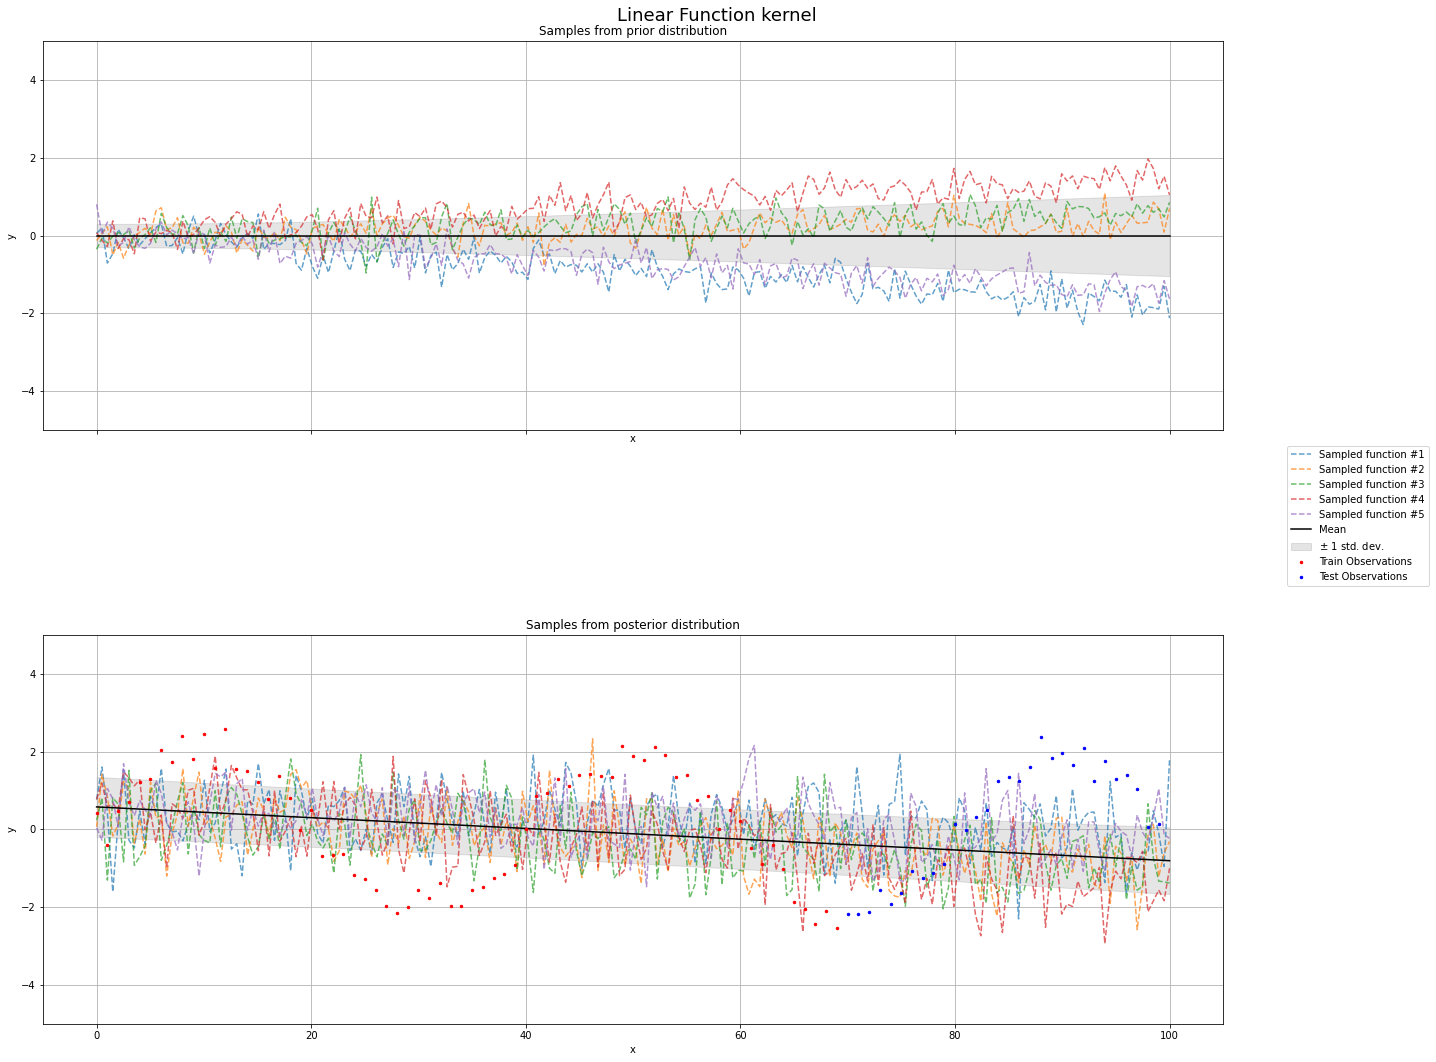

In [15]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp3, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp3_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Linear Function kernel", fontsize=18)
plt.tight_layout()

In [16]:
print(f'R2 Score Train = {gp3_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp3_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp3_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp3_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp3_fitted.predict(X_test)): 0.3f}')

R2 Score Train =  0.071
R2 Score Test = -0.470
MAE Train =  1.257
MAE Test =  1.596
MAPE Train =  2.185
MAPE Test =  3.155


## Análise da variação do tamanho do dataset na performance do modelo

Aqui, iremos implementar o TimeSeriesSplit para analisar as métricas de avaliação em splits de tamanho variado. Observaremos a evolução do r², do mse, do mae e do mape ao longo do tempo. O que aconteceu com as métricas com o aumento do tamanho do dataset de treino ? Qual foi o melhor modelo? Plote as evoluções ao longo do tempo em um gráfico de ponto-linha.

In [17]:
# Definição dos kernels a serem testados
kernels = [kernel_1, kernel_2, kernel_3]

tscv = TimeSeriesSplit(n_splits=5)
model = GaussianProcessRegressor()
param_search = {'model__kernel': kernels, 'model__alpha': [1e-2, 1e-3]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = False)

In [18]:
# Fit dos dados
gsearch.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                                           WhiteKernel(noise_level=0.09) + 1.41**2 * RBF(length_scale=1),
                                           WhiteKernel(noise_level=0.09) + 0.01**2 * DotProduct(sigma_0=1)]},
             refit=False,
             scoring={'R2': 'r2', 'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
                      'mse': 'neg_root_mean_squared_error'})

## Analisando os modelos obtidos

In [19]:
# Obtendo as métricas de avaliação
results = pd.DataFrame(gsearch.cv_results_)
models_names = ['ExpSineSquared', 'RBF', 'Linear']
r2_results = {}
splits = [0,1,2,3,4]
for j in range(len(kernels)):
    r2_values = list(results.loc[j,[f'split{i}_test_R2' for i in range(5)]].values)
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    r2_results[model_name] = r2_values

mae_results = {}
for j in range(len(kernels)):
    mae_values = list(results.loc[j,[f'split{i}_test_mae' for i in range(5)]].values)
    mae_values = [-1*value for value in mae_values]
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    mae_results[model_name] = mae_values

mse_results = {}
for j in range(len(kernels)):
    mse_values = list(results.loc[j,[f'split{i}_test_mse' for i in range(5)]].values)
    mse_values = [-1*value for value in mse_values]
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    mse_results[model_name] = mse_values

mape_results = {}
for j in range(len(kernels)):
    mape_values = list(results.loc[j,[f'split{i}_test_mape' for i in range(5)]].values)
    mape_values = [-1*value for value in mape_values]
    model_name = models_names[j]

    #model_name = str(results.loc[j,'param_model__kernel'])
    mape_results[model_name] = mape_values

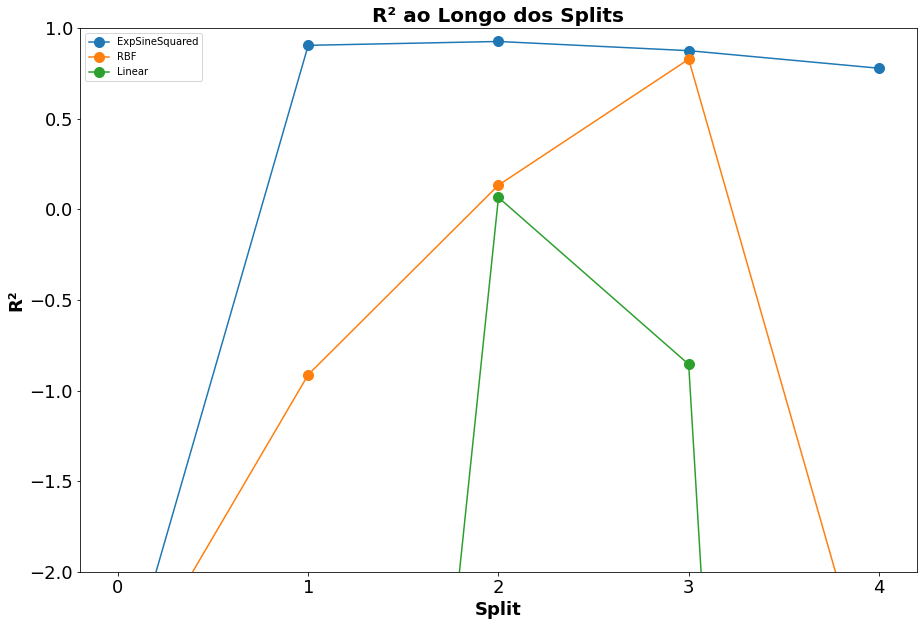

In [20]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,r2_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,r2_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,r2_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('R² ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('R²', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)

ax.set_ylim([-2, 1])
ax.legend()


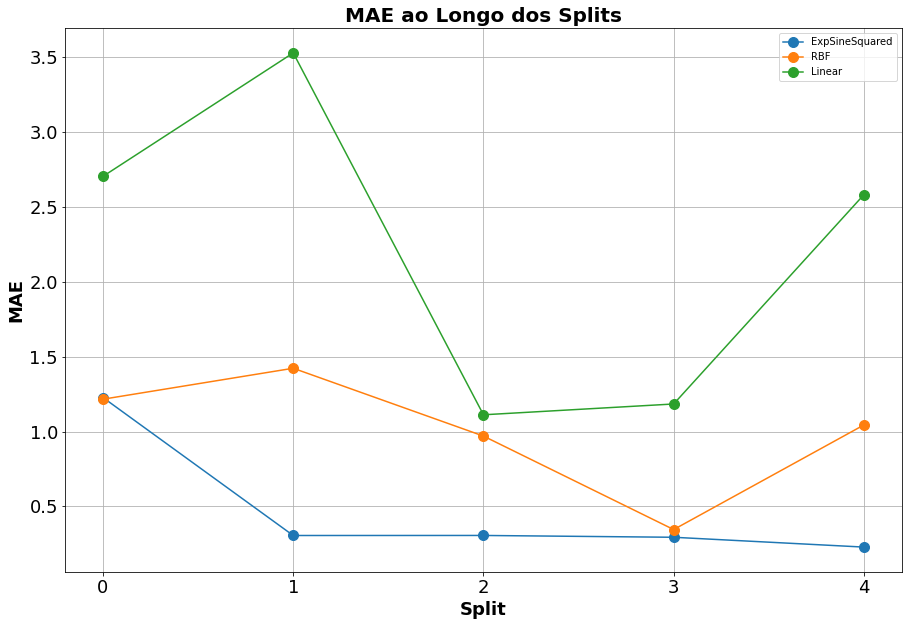

In [21]:
# Gráfico da evolução das métricas - MAE
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mae_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mae_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mae_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('MAE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAE', fontweight = 'bold', fontsize = 18)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend()


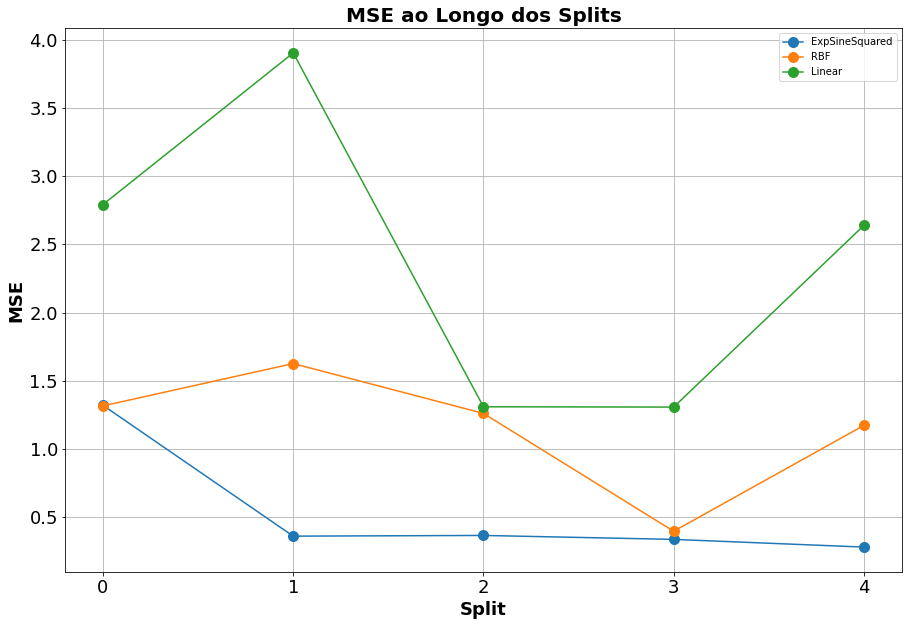

In [22]:
# Gráfico da evolução das métricas - MAE
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mse_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mse_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mse_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('MSE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MSE', fontweight = 'bold', fontsize = 18)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend()


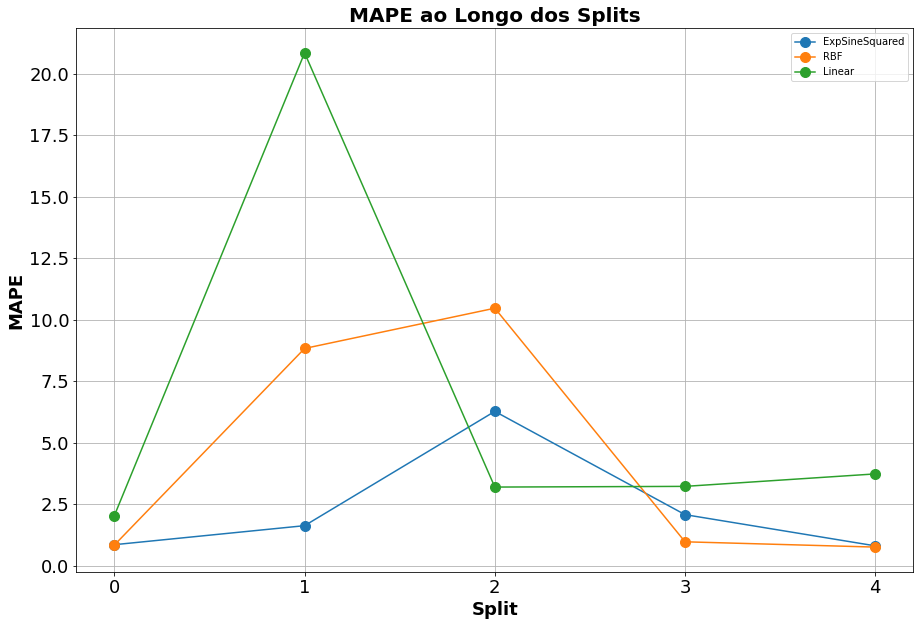

In [23]:
# Gráfico da evolução das métricas - MAE
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mape_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mape_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mape_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('MAPE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAPE', fontweight = 'bold', fontsize = 18)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend()


# Problema #2 - Tendência

Aqui iremos repetir o procedimento anterior dessa vez analisando apenas um conjunto de dados de tendência. Vamos tentar observar a mudança na performance dos kernels a partir de uma mudança na característica dos dados. A ideia aqui é novamente de analisar o que acontece com a diminuição do tamanho do dataset. Iremos tentar validar o procedimento de código já proposto

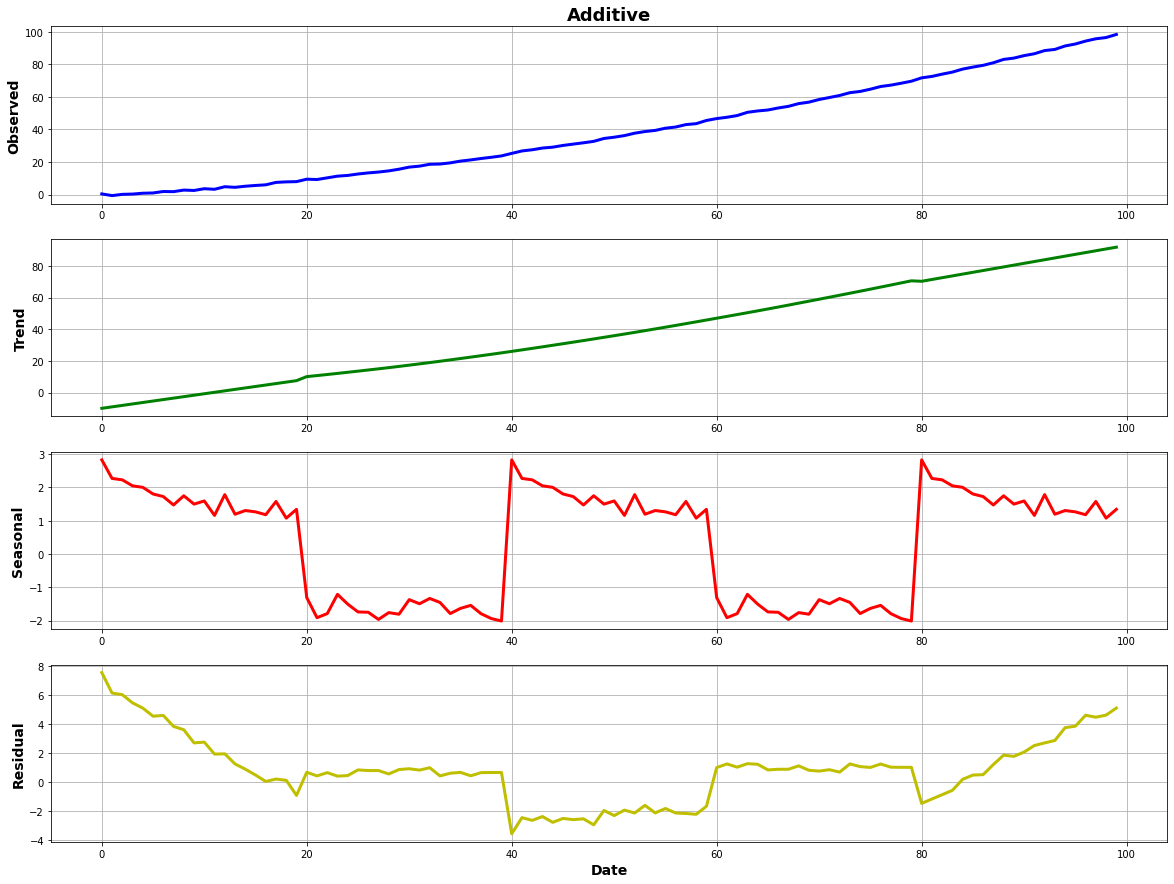

In [24]:
# Observando os dados já gerados
data_df['y2'] = data_df['linear'] + data_df['epsilon']


# Agregating in months

ts = data_df['y2']

# Decomposing using seasonal_decompose

result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq', period = 40)
#result_mult = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq', period = 1)

# Plot
fig, axs = plt.subplots(figsize = (20,15), nrows = 4, ncols = 1)


axs[0].plot(result_add.observed, linewidth = 3, color = 'b')
axs[0].set_ylabel('Observed', fontsize = 14, fontweight = 'bold')
axs[0].set_title('Additive', fontsize = 18, fontweight = 'bold')
axs[0].grid(True)


axs[1].plot(result_add.trend,linewidth = 3, color = 'g')
axs[1].set_ylabel('Trend', fontsize = 14, fontweight = 'bold')
axs[1].grid(True)

axs[2].plot(result_add.seasonal,linewidth = 3, color = 'r')
axs[2].set_ylabel('Seasonal', fontsize = 14, fontweight = 'bold')
axs[2].grid(True)

axs[3].plot(result_add.resid,linewidth = 3, color = 'y')
axs[3].set_ylabel('Residual', fontsize = 14, fontweight = 'bold')
axs[3].set_xlabel('Date', fontsize = 14, fontweight = 'bold')
axs[3].grid(True)


plt.show()


## Kernel 1: ExpSineSquared

In [25]:
# Preparando os dados

X = np.array(data_df['t']).reshape(-1,1)
y = np.array(data_df['y2'])

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [26]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 

# Criando o modelo gaussiano

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp1_fitted = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)
gp1_fitted.fit(X_train,y_train)


GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True)

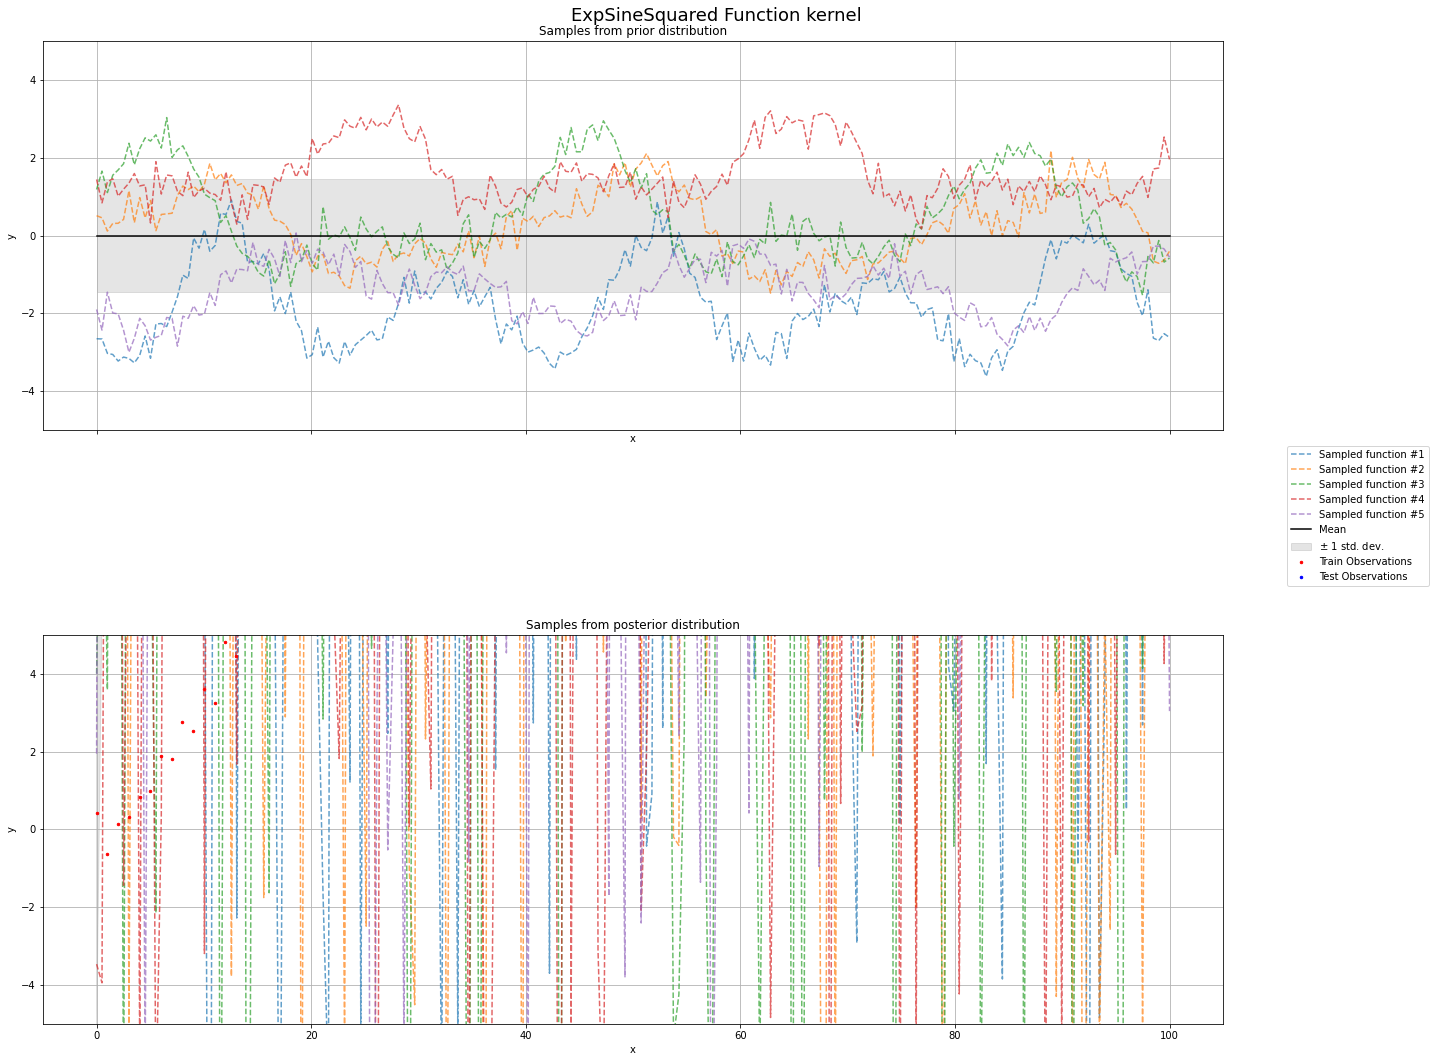

In [27]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp1, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")
axs[0].set_ylim([-20,20])

# plot posterior
plot_gpr_samples(gp1_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("ExpSineSquared Function kernel", fontsize=18)
plt.tight_layout()

In [28]:
print(f'R2 Score Train = {gp1_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp1_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp1_fitted.predict(X_test)): 0.3f}')

R2 Score Train =  0.938
R2 Score Test = -21.023
MAE Train =  3.770
MAE Test =  54.879
MAPE Train =  1.647
MAPE Test =  0.698


## Kernel 2 - RBF

In [29]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  RBF()

kernel_2  = k0 + k1 

# Criando o modelo gaussiano

gp2 = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp2_fitted = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)
gp2_fitted.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)

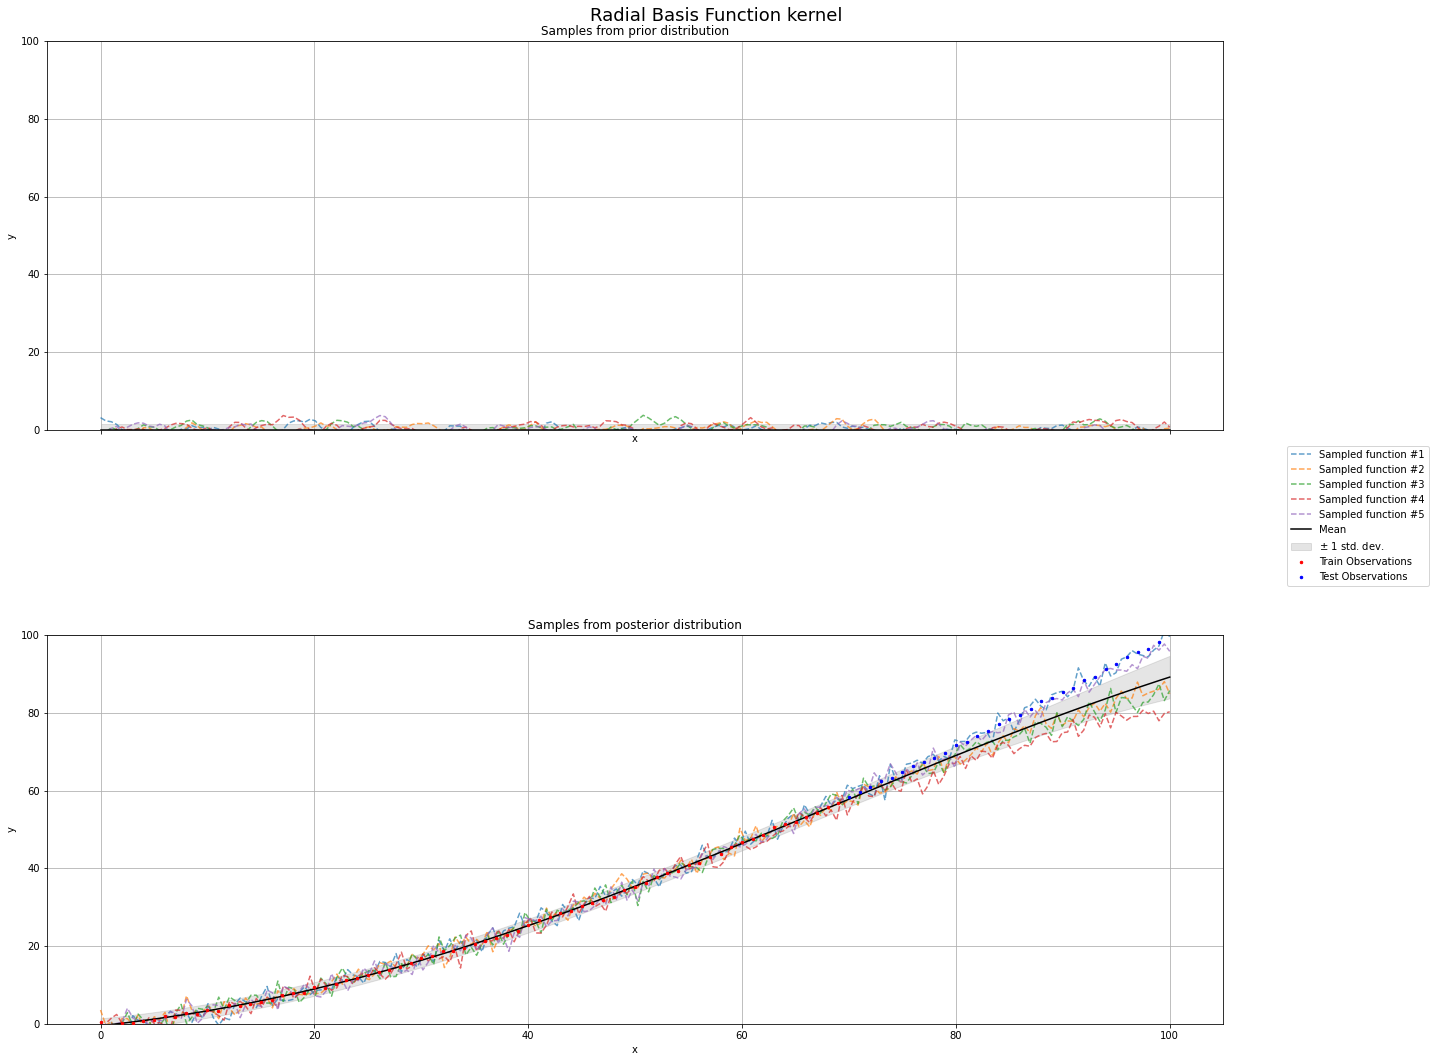

In [30]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp2, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp2_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")
axs[1].set_ylim([0, 100])
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Radial Basis Function kernel", fontsize=18)
plt.tight_layout()

In [31]:
print(f'R2 Score Train = {gp2_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp2_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp2_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp2_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp2_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp2_fitted.predict(X_test)): 0.3f}')


R2 Score Train =  1.000
R2 Score Test =  0.817
MAE Train =  0.277
MAE Test =  4.237
MAPE Train =  0.077
MAPE Test =  0.050


## Kernel 3 - Linear

In [32]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=1e-3) * \
  DotProduct(sigma_0=0.5)**1.5

# kernel = ConstantKernel(0.1, (0.01, 10.0)) * (
#     DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2
# )
kernel_3  = k0 + k1 

# Criando o modelo gaussiano

gp3 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp3_fitted = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.5
)
gp3_fitted.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.5,
                         kernel=WhiteKernel(noise_level=0.09) + 0.0316**2 * DotProduct(sigma_0=0.5) ** 1.5,
                         n_restarts_optimizer=10, normalize_y=True)

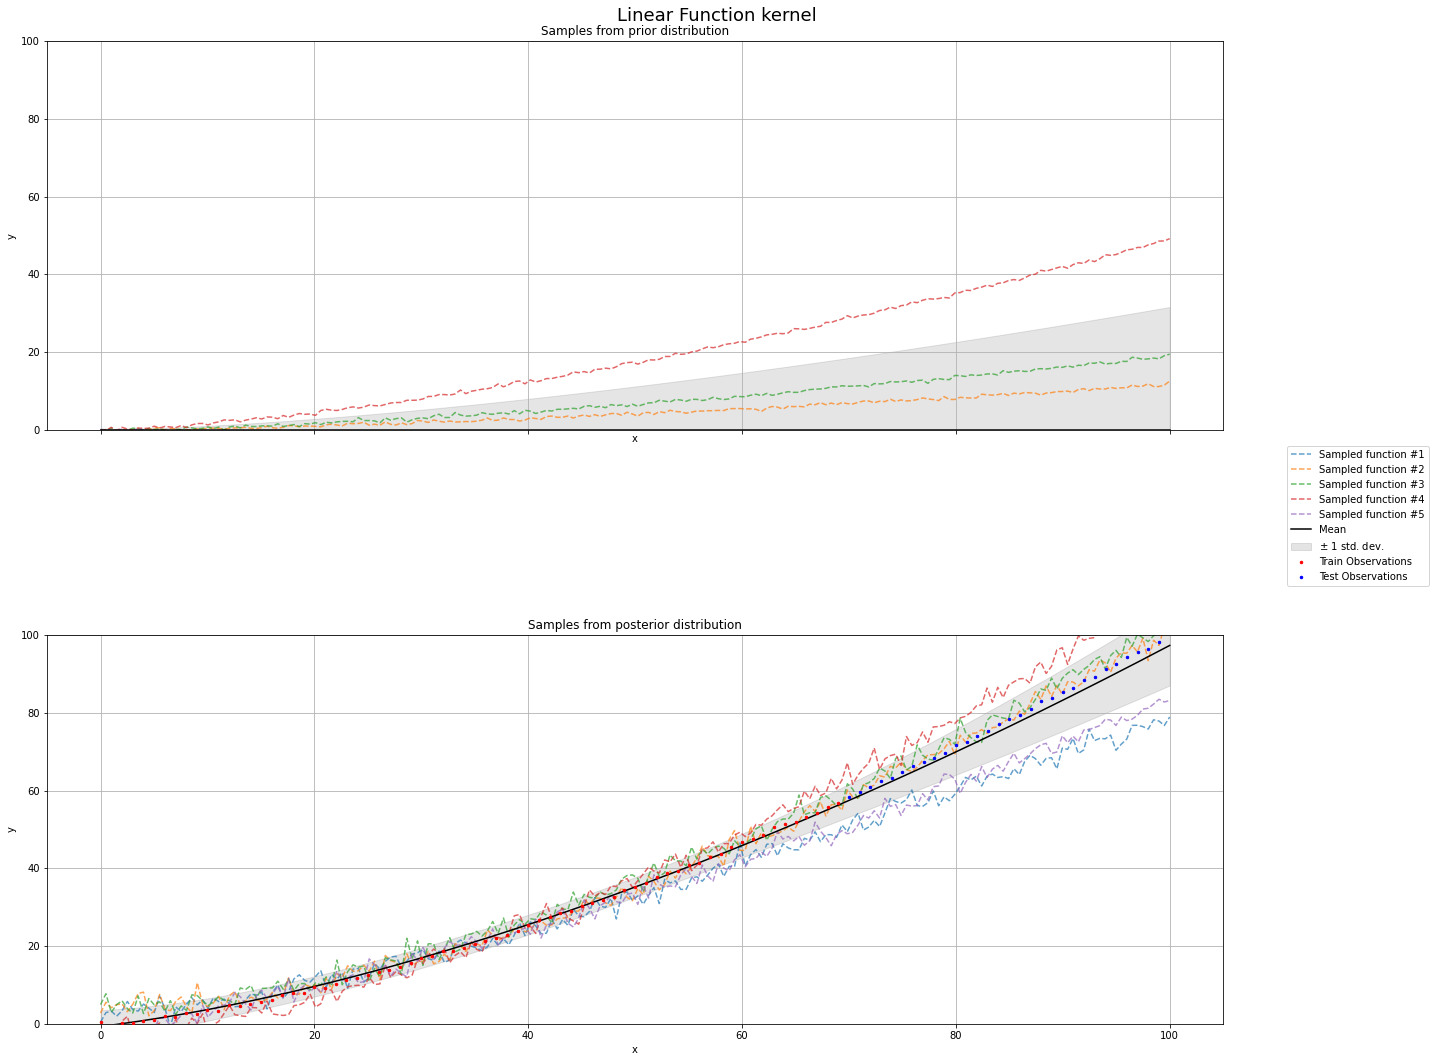

In [45]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp3, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp3_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")
axs[0].set_ylim([0,100])

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Linear Function kernel", fontsize=18)
plt.tight_layout()

In [34]:
print(f'R2 Score Train = {gp3_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp3_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp3_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp3_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp3_fitted.predict(X_test)): 0.3f}')


R2 Score Train =  0.999
R2 Score Test =  0.978
MAE Train =  0.464
MAE Test =  1.707
MAPE Train =  0.103
MAPE Test =  0.021


## Analisando a variação do tamanho do dataset

In [35]:
# Definição dos kernels a serem testados
kernels = [kernel_1, kernel_2, kernel_3]

tscv = TimeSeriesSplit(n_splits=5)
model = GaussianProcessRegressor()
param_search = {'model__kernel': kernels, 'model__alpha': [1e-2, 1e-3]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = False)
                        

In [36]:
# Fit dos dados
gsearch.fit(X,y)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                                           WhiteKernel(noise_level=0.09) + 1.41**2 * RBF(length_scale=1),
                                           WhiteKernel(noise_level=0.09) + 0.0316**2 * DotProduct(sigma_0=0.5) ** 1.5]},
             refit=False,
             scoring={'R2': 'r2', 'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
                      'mse': 'neg_root_mean_squared_error'})

In [37]:
# Obtendo as métricas de avaliação
results = pd.DataFrame(gsearch.cv_results_)
models_names = ['ExpSineSquared', 'RBF', 'Linear']
r2_results = {}
splits = [0,1,2,3,4]
for j in range(len(kernels)):
    r2_values = list(results.loc[j,[f'split{i}_test_R2' for i in range(5)]].values)
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    r2_results[model_name] = r2_values

mae_results = {}
for j in range(len(kernels)):
    mae_values = list(results.loc[j,[f'split{i}_test_mae' for i in range(5)]].values)
    mae_values = [-1*value for value in mae_values]
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    mae_results[model_name] = mae_values

mse_results = {}
for j in range(len(kernels)):
    mse_values = list(results.loc[j,[f'split{i}_test_mse' for i in range(5)]].values)
    mse_values = [-1*value for value in mse_values]
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    mse_results[model_name] = mse_values

mape_results = {}
for j in range(len(kernels)):
    mape_values = list(results.loc[j,[f'split{i}_test_mape' for i in range(5)]].values)
    mape_values = [-1*value for value in mape_values]
    model_name = models_names[j]

    #model_name = str(results.loc[j,'param_model__kernel'])
    mape_results[model_name] = mape_values


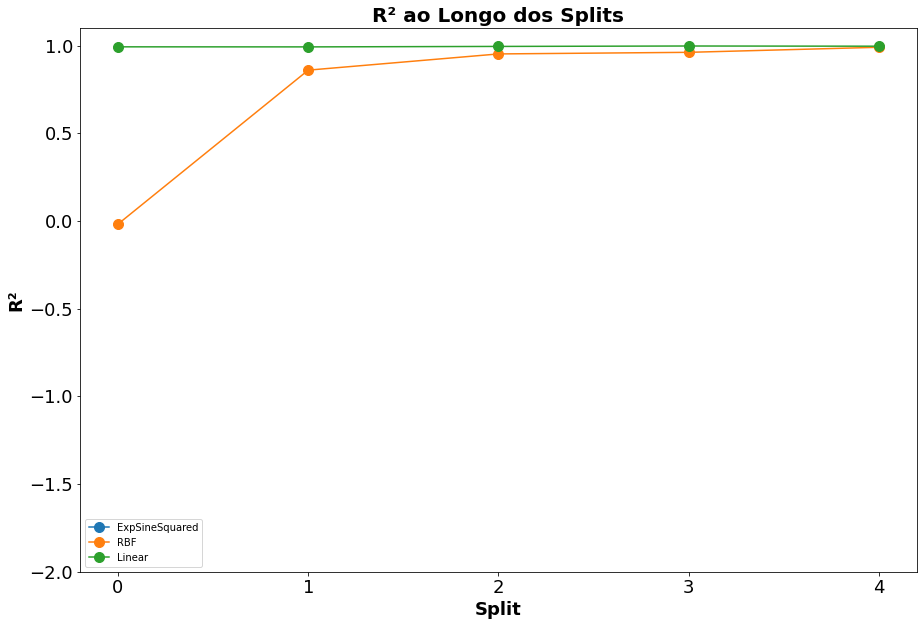

In [38]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,r2_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,r2_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,r2_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('R² ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('R²', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim([-2, 1.1])

ax.legend()

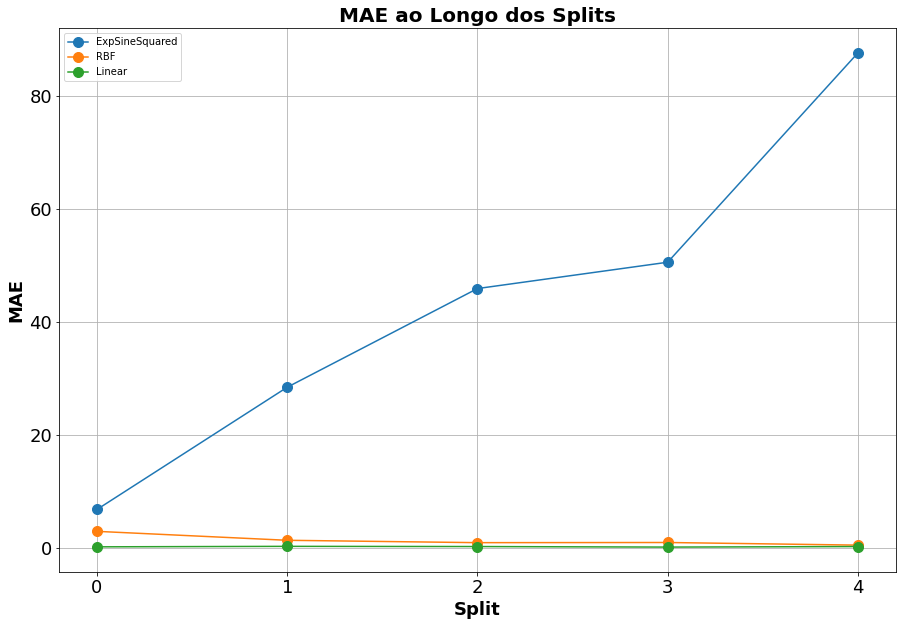

In [39]:
# Gráfico da evolução das métricas - MAE
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mae_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mae_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mae_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('MAE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAE', fontweight = 'bold', fontsize = 18)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend()

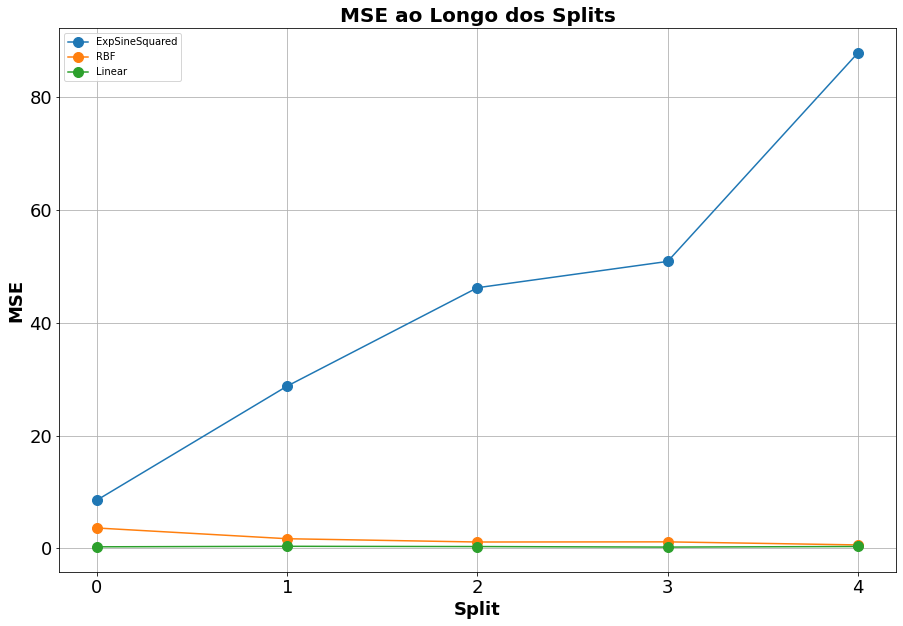

In [40]:
# Gráfico da evolução das métricas - MAE
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mse_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mse_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mse_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('MSE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MSE', fontweight = 'bold', fontsize = 18)
ax.grid()

ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend()

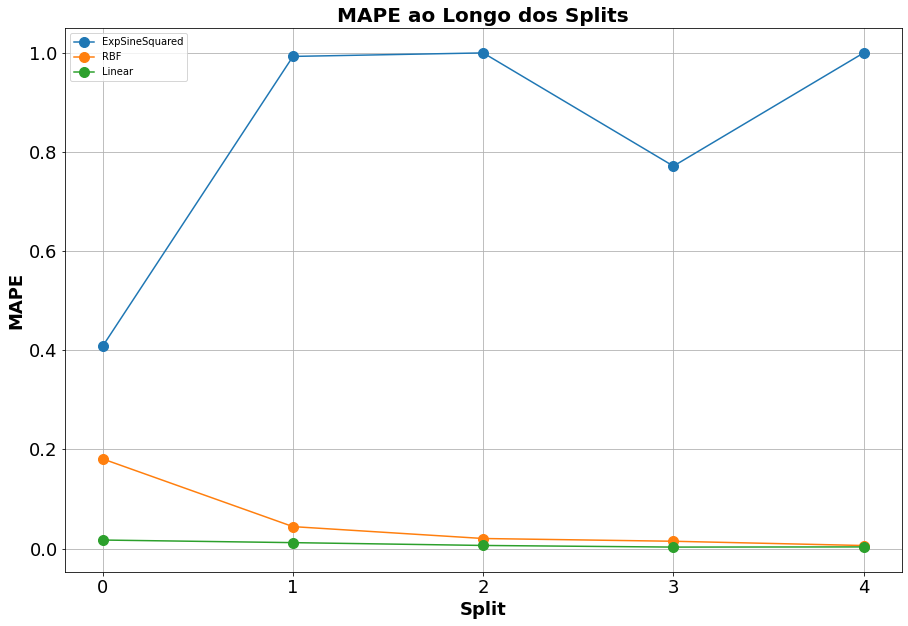

In [41]:


# Gráfico da evolução das métricas - MAE
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mape_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mape_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mape_results['Linear'], marker = '.', markersize = 20, label = 'Linear')

plt.xticks(splits)  

ax.set_title('MAPE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAPE', fontweight = 'bold', fontsize = 18)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend()

# Problema #3 - Tendência e Sazonalidade

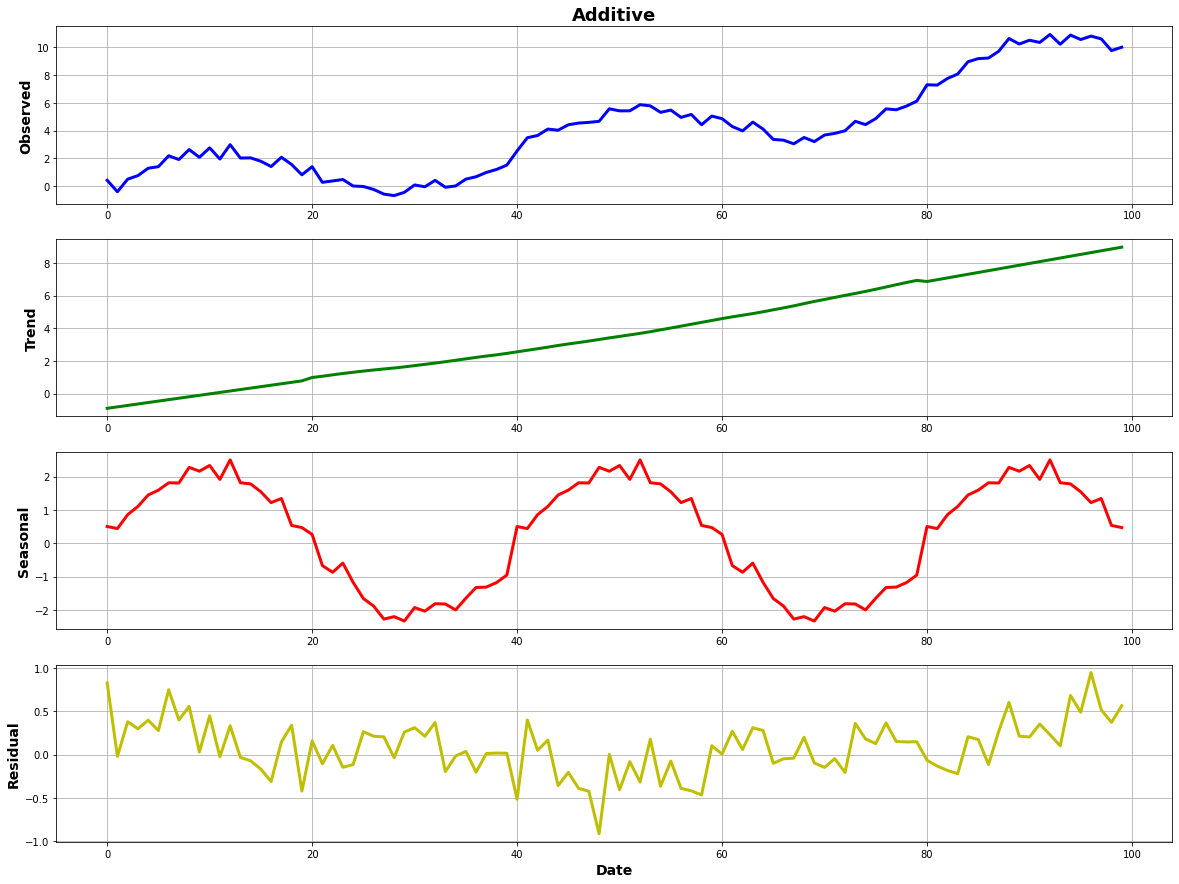

In [48]:
# Definindo a variável alvo
data_df['y3'] = data_df['seasonal'] + data_df['epsilon'] + data_df['linear']/10


# Agregating in months

ts = data_df['y3']

# Decomposing using seasonal_decompose

result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq', period = 40)
#result_mult = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq', period = 1)

# Plot
fig, axs = plt.subplots(figsize = (20,15), nrows = 4, ncols = 1)


axs[0].plot(result_add.observed, linewidth = 3, color = 'b')
axs[0].set_ylabel('Observed', fontsize = 14, fontweight = 'bold')
axs[0].set_title('Additive', fontsize = 18, fontweight = 'bold')
axs[0].grid(True)


axs[1].plot(result_add.trend,linewidth = 3, color = 'g')
axs[1].set_ylabel('Trend', fontsize = 14, fontweight = 'bold')
axs[1].grid(True)

axs[2].plot(result_add.seasonal,linewidth = 3, color = 'r')
axs[2].set_ylabel('Seasonal', fontsize = 14, fontweight = 'bold')
axs[2].grid(True)

axs[3].plot(result_add.resid,linewidth = 3, color = 'y')
axs[3].set_ylabel('Residual', fontsize = 14, fontweight = 'bold')
axs[3].set_xlabel('Date', fontsize = 14, fontweight = 'bold')
axs[3].grid(True)


plt.show()


## Kernel 1: ExpSineSquared

In [49]:
# Preparando os dados

X = np.array(data_df['t']).reshape(-1,1)
y = np.array(data_df['y3'])

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]


In [50]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 

# Criando o modelo gaussiano

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp1_fitted = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)
gp1_fitted.fit(X_train,y_train)


GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True)

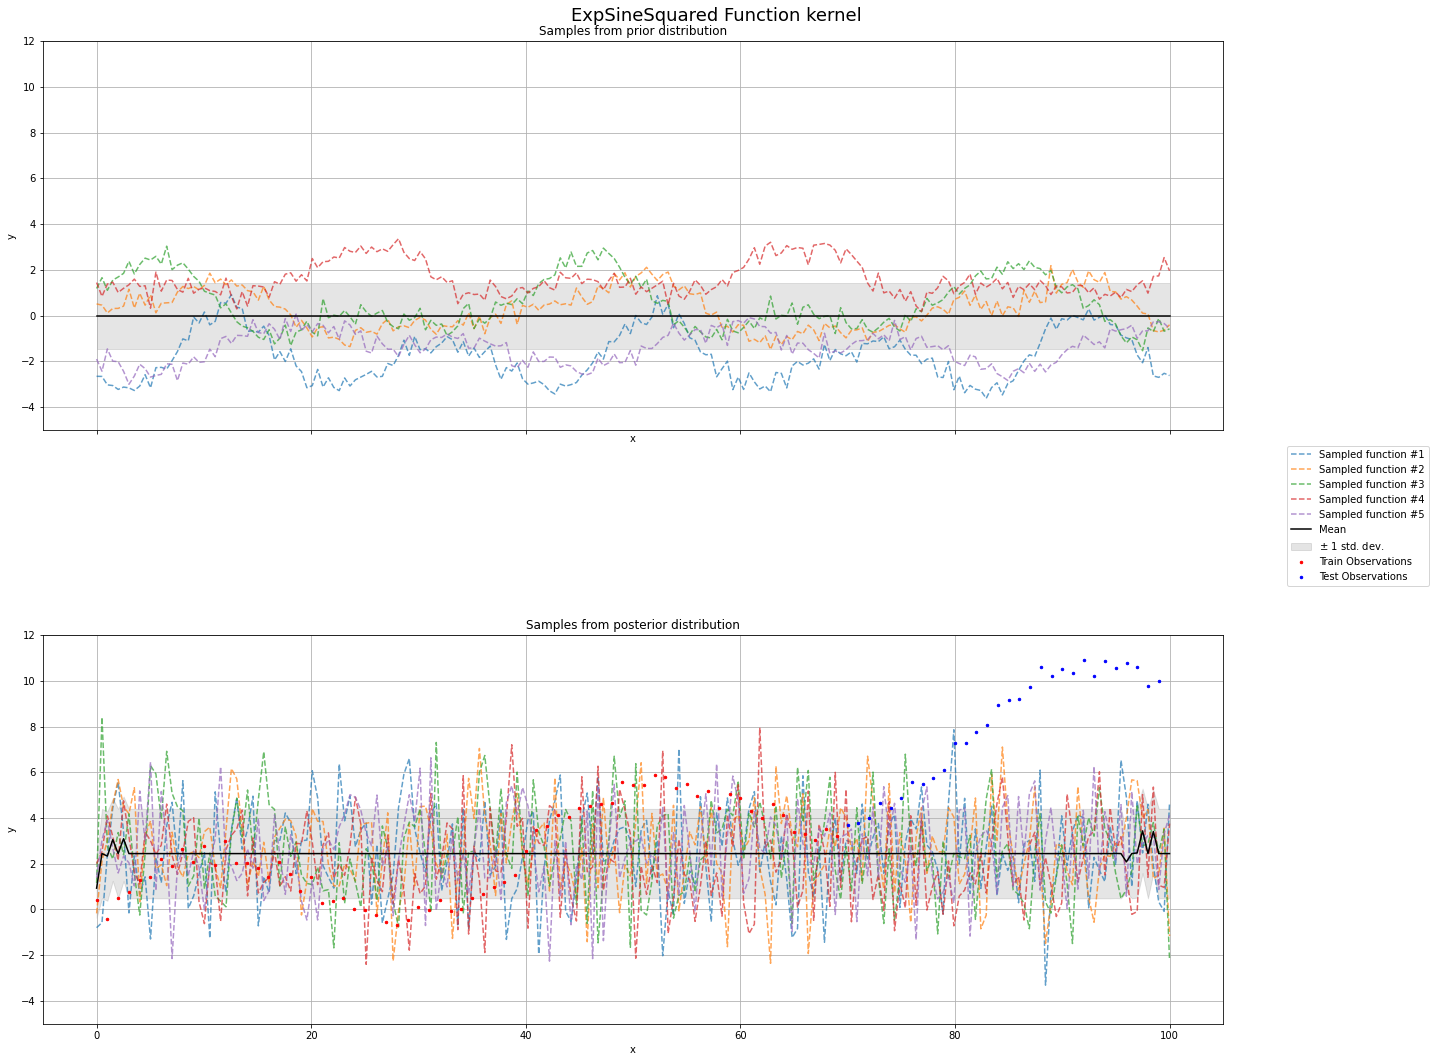

In [53]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp1, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp1_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")
axs[1].set_ylim([-5,12])


axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("ExpSineSquared Function kernel", fontsize=18)
plt.tight_layout()

In [54]:
print(f'R2 Score Train = {gp1_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp1_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp1_fitted.predict(X_test)): 0.3f}')


R2 Score Train =  0.938
R2 Score Test = -5.003
MAE Train =  0.432
MAE Test =  5.599
MAPE Train =  2.296
MAPE Test =  0.655


## Kernel 2 - RBF

In [55]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  RBF()

kernel_2  = k0 + k1 

# Criando o modelo gaussiano

gp2 = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp2_fitted = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)
gp2_fitted.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)

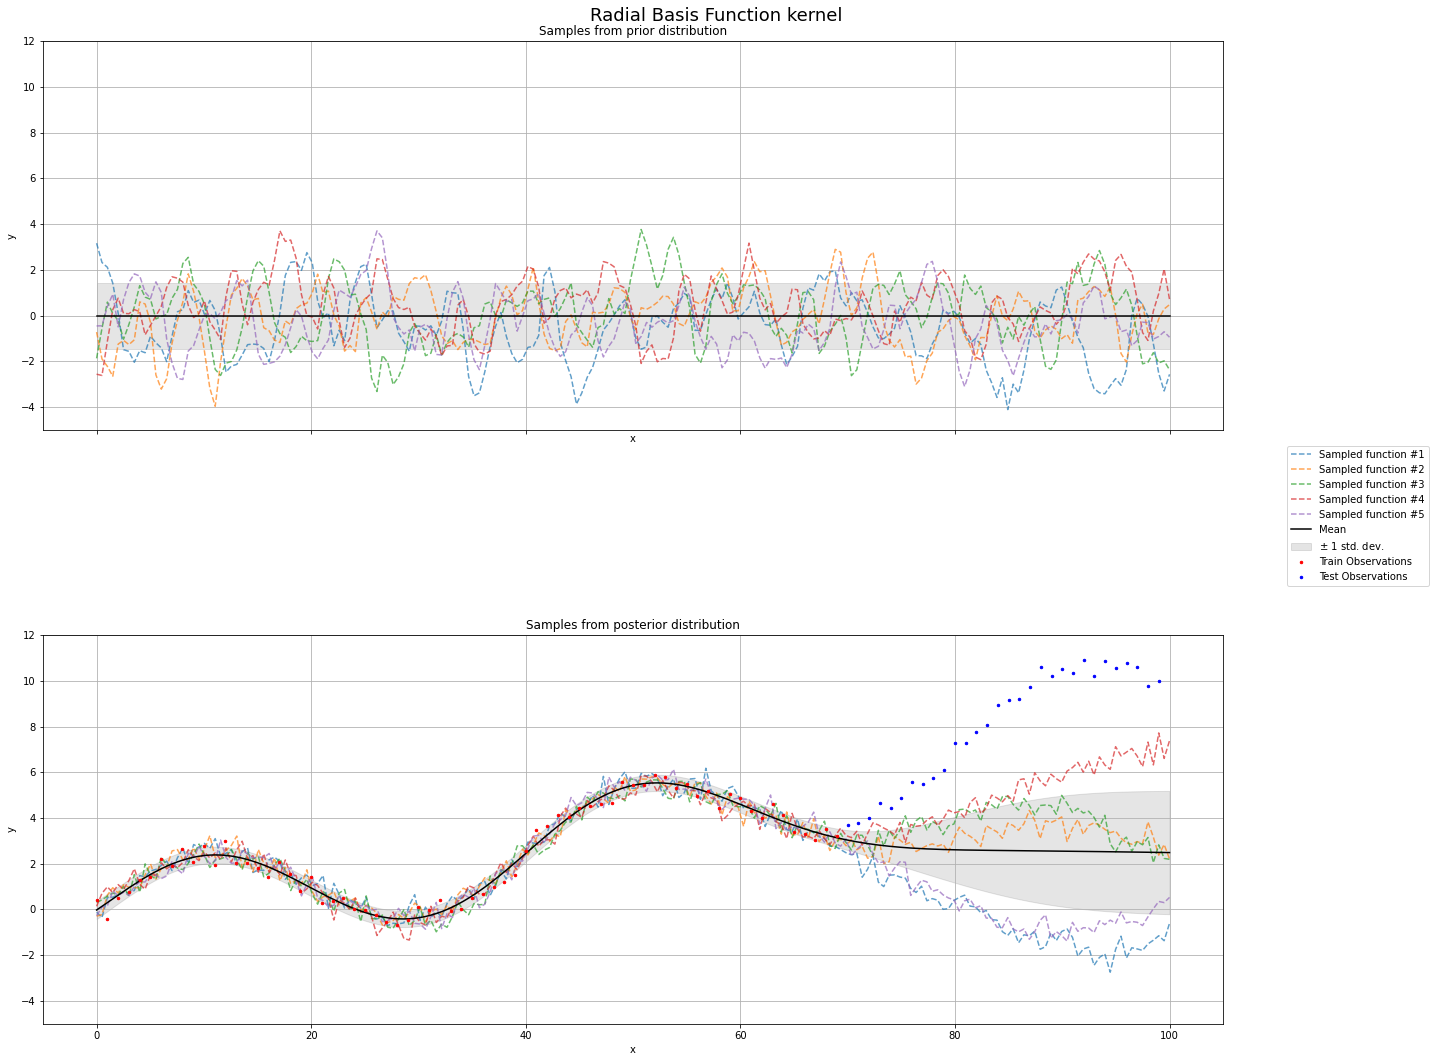

In [57]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp2, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp2_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")
axs[1].set_ylim([-5, 12])
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Radial Basis Function kernel", fontsize=18)
plt.tight_layout()

In [58]:
print(f'R2 Score Train = {gp2_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp2_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp2_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp2_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp2_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp2_fitted.predict(X_test)): 0.3f}')

R2 Score Train =  0.973
R2 Score Test = -4.778
MAE Train =  0.270
MAE Test =  5.416
MAPE Train =  0.710
MAPE Test =  0.622


## Kernel 3 - Linear

In [62]:
# Definindo o Kernel
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=1e-4) * \
  DotProduct(sigma_0=0.5)**1.5

# kernel = ConstantKernel(0.1, (0.01, 10.0)) * (
#     DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2
# )
kernel_3  = k0 + k1 

# Criando o modelo gaussiano

gp3 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp3_fitted = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.5
)
gp3_fitted.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.5,
                         kernel=WhiteKernel(noise_level=0.09) + 0.01**2 * DotProduct(sigma_0=0.5) ** 1.5,
                         n_restarts_optimizer=10, normalize_y=True)

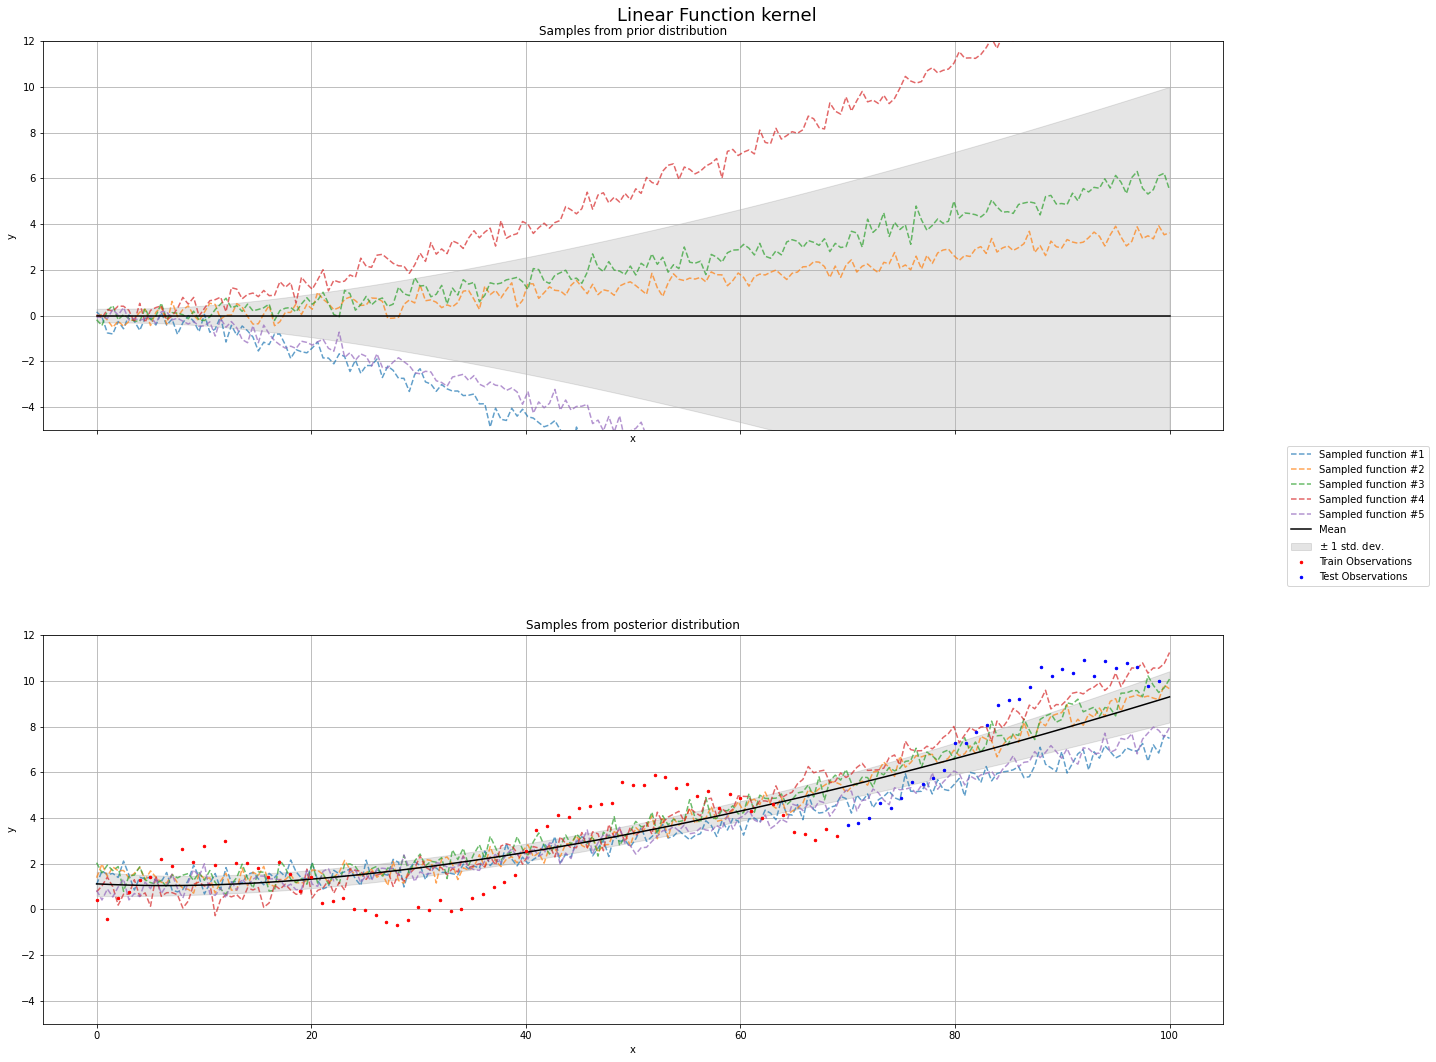

In [63]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp3, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp3_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")
axs[0].set_ylim([-5,12])

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Linear Function kernel", fontsize=18)
plt.tight_layout()

In [64]:
print(f'R2 Score Train = {gp3_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp3_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp3_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp3_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp3_fitted.predict(X_test)): 0.3f}')

R2 Score Train =  0.491
R2 Score Test =  0.525
MAE Train =  1.237
MAE Test =  1.560
MAPE Train =  6.434
MAPE Test =  0.204


## Kernel 4 - ExpSineSquared + Linear

In [66]:
kernel_4  = kernel_1 + kernel_3 

# Criando o modelo gaussiano

gp4 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)


# Criando um modelo fittado só para observar as distribuições posteriori
gp4_fitted = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.5
)
gp4_fitted.fit(X_train,y_train)

GaussianProcessRegressor(alpha=0.5,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + WhiteKernel(noise_level=0.09) + 0.01**2 * DotProduct(sigma_0=0.5) ** 1.5,
                         n_restarts_optimizer=10, normalize_y=True)

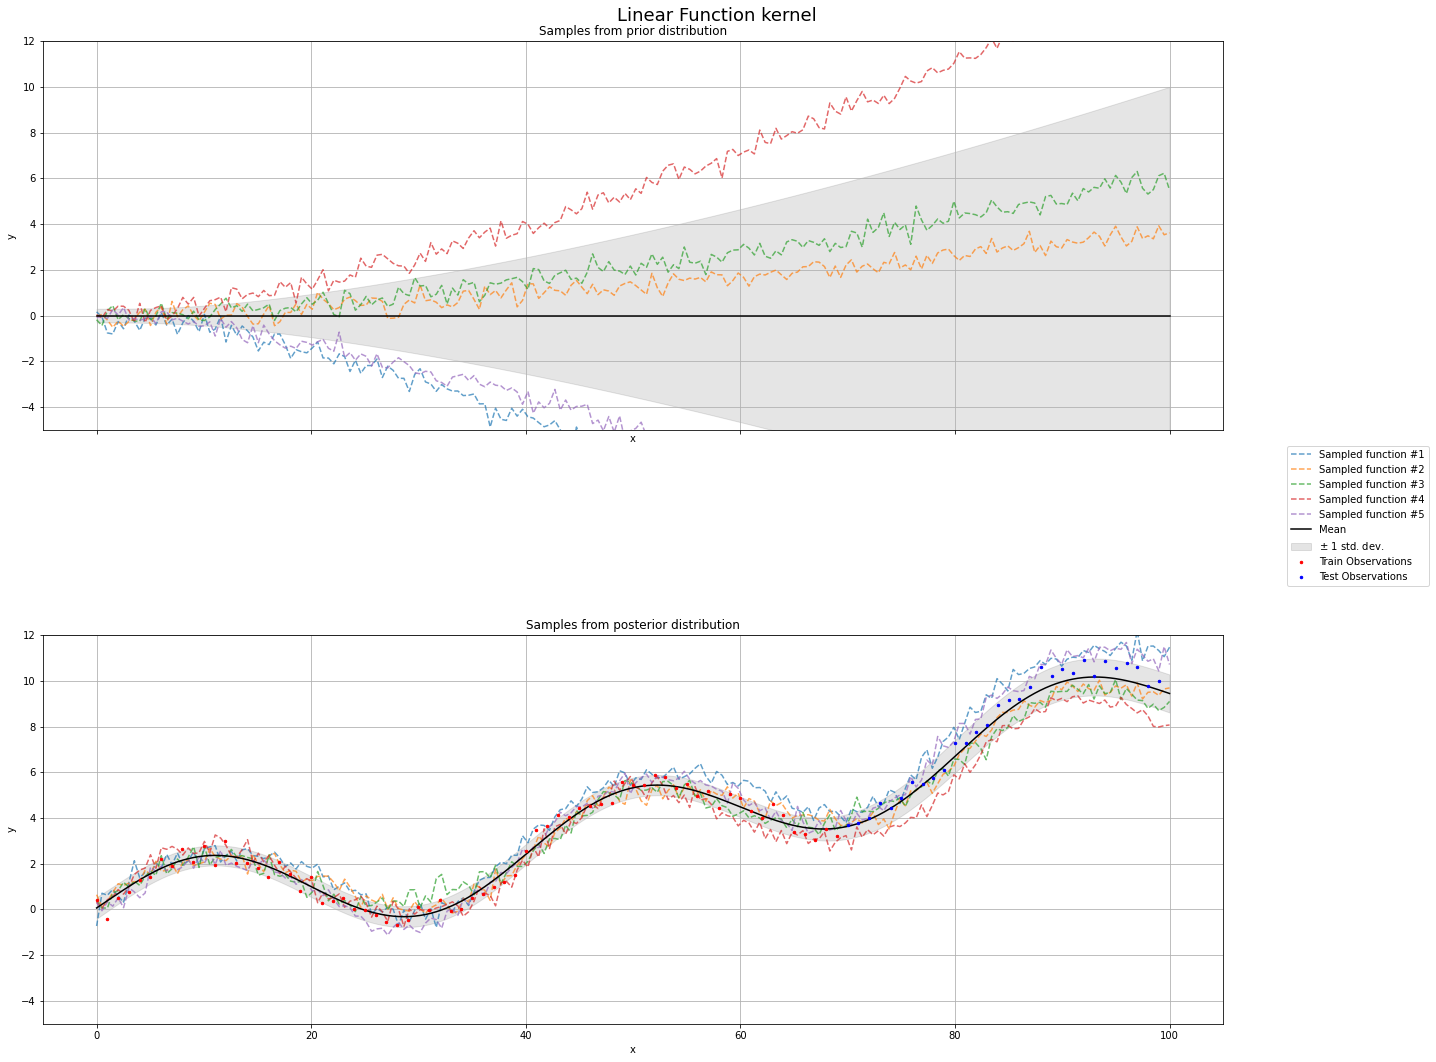

In [67]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 15))

# plot prior
plot_gpr_samples(gp4, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gp4_fitted, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, s = 6, color="red", zorder=10, label="Train Observations")
axs[1].scatter(X_test[:, 0], y_test,s = 6, color="blue", zorder=10, label="Test Observations")
axs[0].set_ylim([-5,12])

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

fig.suptitle("Linear Function kernel", fontsize=18)
plt.tight_layout()

In [68]:
print(f'R2 Score Train = {gp4_fitted.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp4_fitted.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp4_fitted.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp4_fitted.predict(X_test)): 0.3f}')
print(f'MAPE Train = {mean_absolute_percentage_error(y_true=y_train, y_pred=gp4_fitted.predict(X_train)): 0.3f}')
print(f'MAPE Test = {mean_absolute_percentage_error(y_true=y_test, y_pred=gp4_fitted.predict(X_test)): 0.3f}')

R2 Score Train =  0.970
R2 Score Test =  0.968
MAE Train =  0.285
MAE Test =  0.347
MAPE Train =  0.752
MAPE Test =  0.040


# Analisando o tamanho do dataset

In [69]:
# Definição dos kernels a serem testados
kernels = [kernel_1, kernel_2, kernel_3, kernel_4]

tscv = TimeSeriesSplit(n_splits=5)
model = GaussianProcessRegressor()
param_search = {'model__kernel': kernels, 'model__alpha': [1e-2, 1e-3]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = False)

In [70]:
# Fit dos dados
gsearch.fit(X,y)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                                           WhiteKernel(noise_level=0.09) + 1.41**2 * RBF(length_scale=1),
                                           W...ise_level=0.09) + 0.01**2 * DotProduct(sigma_0=0.5) ** 1.5,
                                           WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40) + WhiteKernel(noise_level=0.09) + 0.01**2 * DotProduct(sigma_0=0.5) ** 1.5]},
             refit=False,
             scoring={'R2': 'r2', 'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
                      'mse': 'neg_root_mean_squared_error

In [71]:
# Obtendo as métricas de avaliação
results = pd.DataFrame(gsearch.cv_results_)
models_names = ['ExpSineSquared', 'RBF', 'Linear', 'ExpSineSquared + Lineear']
r2_results = {}
splits = [0,1,2,3,4]
for j in range(len(kernels)):
    r2_values = list(results.loc[j,[f'split{i}_test_R2' for i in range(5)]].values)
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    r2_results[model_name] = r2_values

mae_results = {}
for j in range(len(kernels)):
    mae_values = list(results.loc[j,[f'split{i}_test_mae' for i in range(5)]].values)
    mae_values = [-1*value for value in mae_values]
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    mae_results[model_name] = mae_values

mse_results = {}
for j in range(len(kernels)):
    mse_values = list(results.loc[j,[f'split{i}_test_mse' for i in range(5)]].values)
    mse_values = [-1*value for value in mse_values]
    model_name = models_names[j]
    #model_name = str(results.loc[j,'param_model__kernel'])
    mse_results[model_name] = mse_values

mape_results = {}
for j in range(len(kernels)):
    mape_values = list(results.loc[j,[f'split{i}_test_mape' for i in range(5)]].values)
    mape_values = [-1*value for value in mape_values]
    model_name = models_names[j]

    #model_name = str(results.loc[j,'param_model__kernel'])
    mape_results[model_name] = mape_values

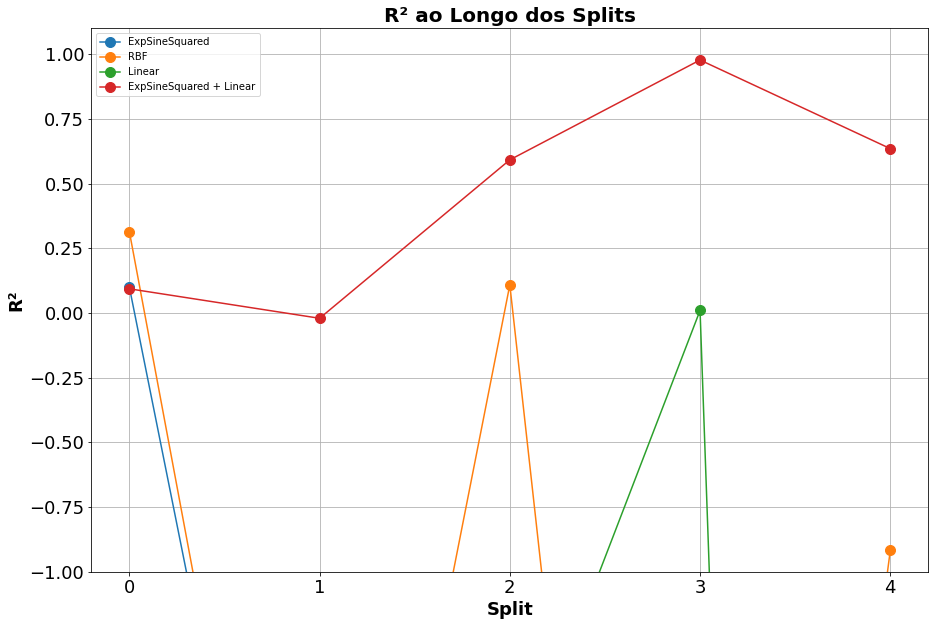

In [77]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,r2_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,r2_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,r2_results['Linear'], marker = '.', markersize = 20, label = 'Linear')
ax.plot(splits,r2_results['ExpSineSquared + Lineear'], marker = '.', markersize = 20, label = 'ExpSineSquared + Linear')


plt.xticks(splits)  

ax.set_title('R² ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('R²', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim([-1, 1.1])
ax.grid(True)

ax.legend()

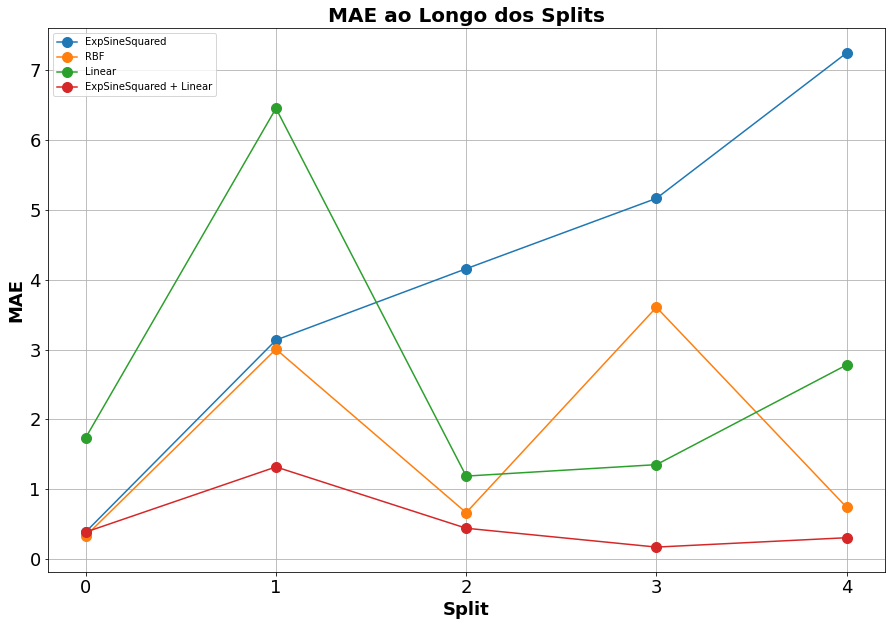

In [79]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mae_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mae_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mae_results['Linear'], marker = '.', markersize = 20, label = 'Linear')
ax.plot(splits,mae_results['ExpSineSquared + Lineear'], marker = '.', markersize = 20, label = 'ExpSineSquared + Linear')


plt.xticks(splits)  

ax.set_title('MAE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True)

ax.legend()

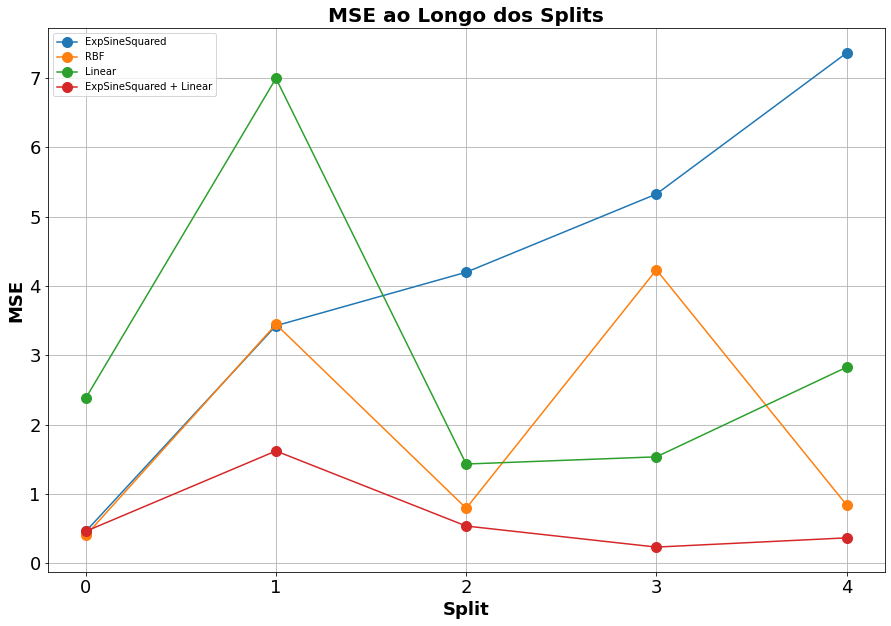

In [80]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mse_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mse_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mse_results['Linear'], marker = '.', markersize = 20, label = 'Linear')
ax.plot(splits,mse_results['ExpSineSquared + Lineear'], marker = '.', markersize = 20, label = 'ExpSineSquared + Linear')


plt.xticks(splits)  

ax.set_title('MSE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MSE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True)

ax.legend()

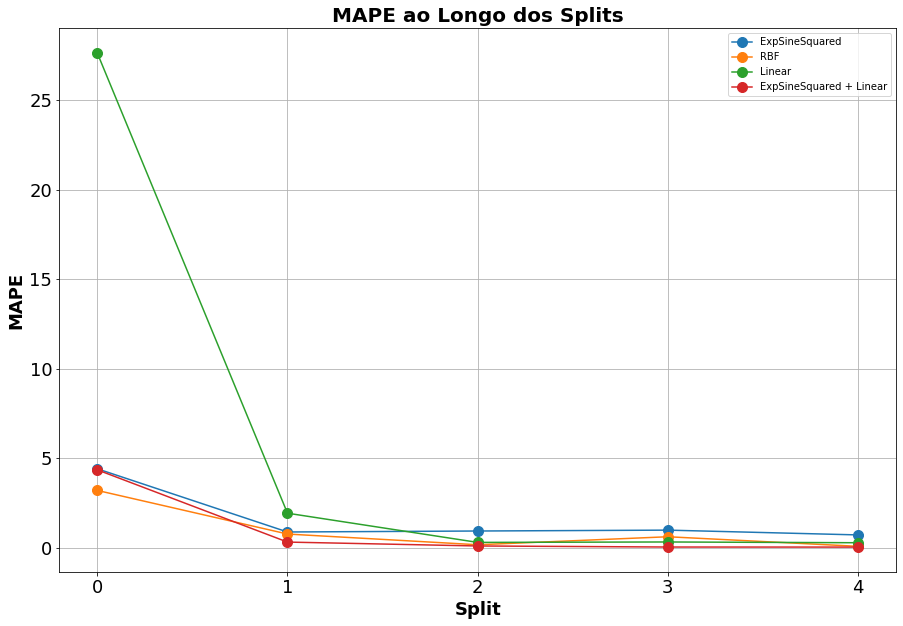

In [81]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(splits,mape_results['ExpSineSquared'], marker = '.', markersize = 20, label = 'ExpSineSquared')
ax.plot(splits,mape_results['RBF'], marker = '.', markersize = 20, label = 'RBF')
ax.plot(splits,mape_results['Linear'], marker = '.', markersize = 20, label = 'Linear')
ax.plot(splits,mape_results['ExpSineSquared + Lineear'], marker = '.', markersize = 20, label = 'ExpSineSquared + Linear')


plt.xticks(splits)  

ax.set_title('MAPE ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('MAPE', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True)

ax.legend()